# Probabilistic Forecasting with `sktime`

### Overview of this notebook

* probabilistic prediction: intervals, distributions
    * deep dive into distributional forecasting
    * mathematical foundations
* probability distribution objects (`skpro`)
* probabilistic metrics revisited
    * types of probabilistic metrics
    * mathematical properties, "properness"
* `skpro` tabular probabilistic regressors
    * what is probabilistic tabular regression?
    * time-to-event and waiting time
* building modular `sktime` probabilistic forecasters
    * reduction from forecasting to tabular proba regression
    * reduction from tabular proba regression to tabular regression

"what is this distribution object returned by `predict_proba`?

"which metrics to use for proba forecasts? why do they make sense?"

"how to use MAPIE or ngboost for proba forecasting with `sktime`?"

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np

---
### Revisiting Probabilistic Forecasting with `sktime`

Recall the basic interval prediction vignette

In [3]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster


# step 1: data specification
y = load_airline()
# step 2: specifying forecasting horizon
fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# step 3: specifying the forecasting algorithm
forecaster = ThetaForecaster(sp=12)
# step 4: fitting the forecaster
forecaster.fit(y, fh=fh)
# step 5: querying predictions
y_pred = forecaster.predict()

# for probabilistic forecasting:
#   call a probabilistic forecasting method after or instead of step 5
y_pred_int = forecaster.predict_interval(coverage=0.9)

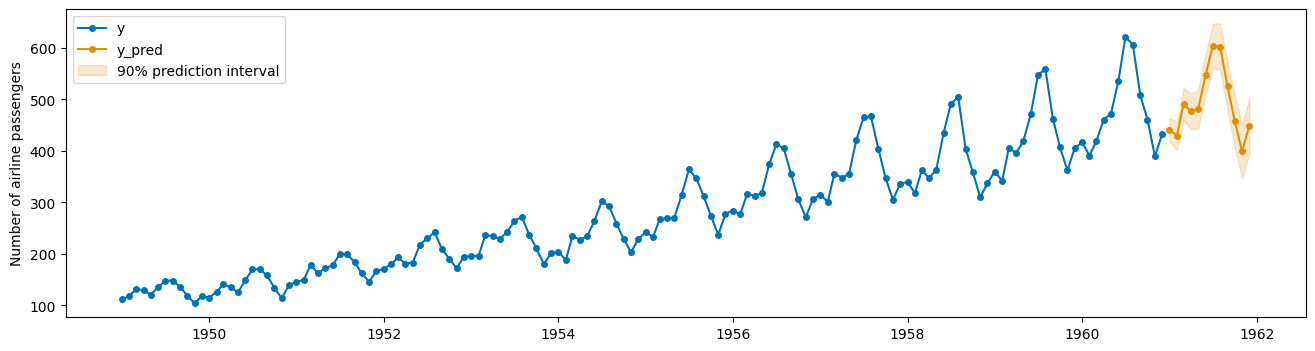

In [4]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_int
)

ax.legend();

All forecasters with tag `capability:pred_int` provide the following:

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* forecast variance     - `predict_var(fh=None, X=None, cov=False)`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

Deep dive into these!

Let's start with distributions, the rest follows from there.

---
### Types of probabilistic forecasts, distributional forecasts

`predict_proba` produces a distributional forecast.

In [5]:
y_pred_proba = forecaster.predict_proba().head(3)

y_pred_proba

Normal(columns=Index(['Number of airline passengers'], dtype='object'),
       index=PeriodIndex(['1961-01', '1961-02', '1961-03'], dtype='period[M]'),
       mu=array([[441.28103617],
       [429.55196778],
       [491.03830627]]),
       sigma=array([[13.98356353],
       [16.61916089],
       [18.89055235]]))

Creating distribution object manually for illustration:

* forecasts for 1960-01, 1960-02, 1960-03
* expected number of passengers: 150, 250, 300
* predicted uncertainty: 50, 60, 70 standard deviation in a normal distribution

In [6]:
import pandas as pd

from skpro.distributions import Normal

timestamps = pd.period_range(start='1960-01', periods=3, freq='M')
variable_names = ["passengers"]

# the syntax is similar to pandas:
# parameters passed as arrays
# index, columns passed

mus = [[150], [250], [300]]
sigmas = [[50], [60], [70]]
n = Normal(mu=mus, sigma=sigmas, index=timestamps, columns=variable_names)

In [7]:
# this is a scikit-base compatible object
# of type "distribution", from skpro.distributions
n

Normal(columns=Index(['passengers'], dtype='object'),
       index=PeriodIndex(['1960-01', '1960-02', '1960-03'], dtype='period[M]'),
       mu=[[150], [250], [300]], sigma=[[50], [60], [70]])

In [8]:
n.to_df()

passengers      
                mu sigma
1960-01        150    50
1960-02        250    60
1960-03        300    70

#### what kind of object are we looking at?

n is an "array distribution with normal marginals"

each entry is a univariate normal rv

`n.iloc[0, 0]` $\sim \mathcal{N} (150, 50)$ (mean-scale parametrization)

In [9]:
n.iloc[0, 0]  # first row, first column

Normal(mu=150.0, sigma=50.0)

`n.iloc[1, 0]` $\sim \mathcal{N} (250, 60)$ (mean-scale parametrization)

In [10]:
n.iloc[1, 0]  # second row, first column

Normal(mu=250.0, sigma=60.0)

`n.iloc[2, 0]` $\sim \mathcal{N} (300, 70)$ (mean-scale parametrization)

In [11]:
n.iloc[2, 0]  # third row, first column

Normal(mu=300.0, sigma=70.0)

let's look at only the first component for now:

In [12]:
n0 = n.iloc[0, 0]
n0

Normal(mu=150.0, sigma=50.0)

let's call this $X = \mathcal{N}(150, 50^2)$

let's "plot" $X$ in different ways, for illustration

#### cdf = cumulative distribution function

y-value = probability of $X$ being less or equal x-value

$F_X(x) := P(X \le x)$

<Axes: xlabel='x', ylabel='cdf(x)'>

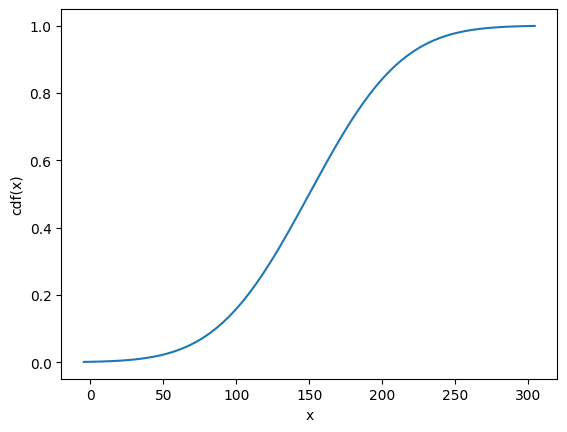

In [13]:
n0.plot("cdf")

if $X$ is a distribution prediction, then quantile predictions are obtained as:

"take quantile point as y-value, find the x-value"

In [14]:
n0.quantile([0.1, 0.25, 0.5, 0.75, 0.9])

Normal                                           
        0.10        0.25   0.50        0.75        0.90
0  85.922422  116.275512  150.0  183.724488  214.077578

#### ppf = percent point function or quantile function = inverse cdf

x-axis = quantile
y-axis = quantile value (e.g., forecast) at that quantile

"p (fraction-percent) of plausible values are below y-value"

$p = P(X \le Q_X(p))$, as a definition of $Q_X$; this implies $Q_X(p) = F^{-1}(p)$

<Axes: xlabel='x', ylabel='ppf(x)'>

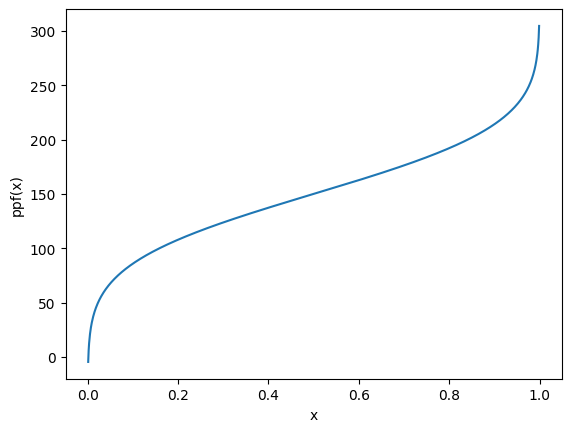

In [15]:
n0.plot("ppf")

if $X$ is a distribution prediction, then quantile predictions are obtained as:

"take quantile point as x-value, find the y-value"

In [16]:
n0.quantile([0.1, 0.25, 0.5, 0.75, 0.9])

Normal                                           
        0.10        0.25   0.50        0.75        0.90
0  85.922422  116.275512  150.0  183.724488  214.077578

#### "pdf" = probability density function

describes how likely values are as follows:

probability for value between a and b = integral between a and b

$P(x\le X \le b) = \int_{a}^b p_X(x) \; dx$

$p_X$ only exists for continuous distributions $X$ and if it exists, $\frac{dF(x)}{dx} = p_X(x)$

<Axes: xlabel='x', ylabel='pdf(x)'>

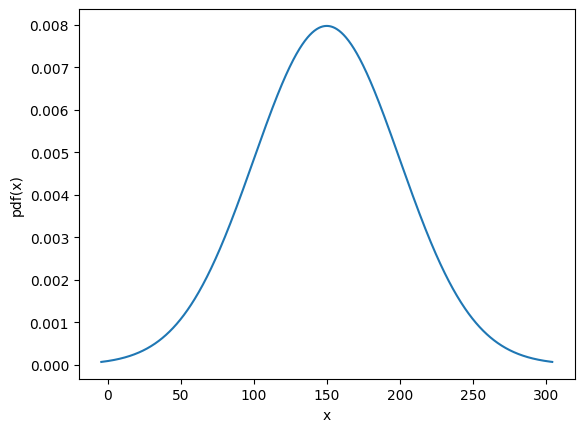

In [17]:
n0.plot("pdf")

#### mean, variance and other distribution statistics

mean $\mu_X$ of $X$ = "expectation" of $X$

$\mathbb{E}[X] := \int_{-\infty}^\infty x p(x)\; dx = \int_0^1 Q_X(p) \; dp$

$\mathbb{V}[X] := \mathbb{E}\left(X - \mathbb{E}[X]\right)^2 = \int_0^1 Q_X(p)^2 \; dp - \mathbb{E}[X]^2$

In [18]:
n0

Normal(mu=150.0, sigma=50.0)

In [19]:
(n0.mean(), n0.var(), np.sqrt(n0.var()))

(150.0, 2500.0, 50.0)

a more empirical view:

* mean is "average of many realizations"
* variance is "average squared difference to mean, over many realizations"

in forecasting, "realizations" = "futures"

In [20]:
a_thousand_futures = n0.sample(10000)
a_thousand_futures

,0
0,59.843424
1,171.375028
2,172.971884
3,73.789138
4,127.956024
...,...
9995,154.904382
9996,167.172079
9997,120.483203
9998,157.863848


In [21]:
a_thousand_futures.mean()

0    150.273065
dtype: float64

In [22]:
((a_thousand_futures - 150)**2).mean()

0    2501.379495
dtype: float64

In [23]:
n0

Normal(mu=150.0, sigma=50.0)

#### array distributions

circling back to `n`, recall that we got `n0` as the first row:

In [24]:
n

Normal(columns=Index(['passengers'], dtype='object'),
       index=PeriodIndex(['1960-01', '1960-02', '1960-03'], dtype='period[M]'),
       mu=[[150], [250], [300]], sigma=[[50], [60], [70]])

In [25]:
n.iloc[0, 0]

Normal(mu=150.0, sigma=50.0)

In [26]:
n.to_df()

passengers      
                mu sigma
1960-01        150    50
1960-02        250    60
1960-03        300    70

In [27]:
n.mean()  # mu = mean

,passengers
1960-01,150
1960-02,250
1960-03,300


In [28]:
np.sqrt(n.var())  # sigma = sqrt(var) = standard deviation

,passengers
1960-01,50.0
1960-02,60.0
1960-03,70.0


(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'passengers'}, ylabel='1960-01'>,
        <Axes: ylabel='1960-02'>, <Axes: ylabel='1960-03'>], dtype=object))

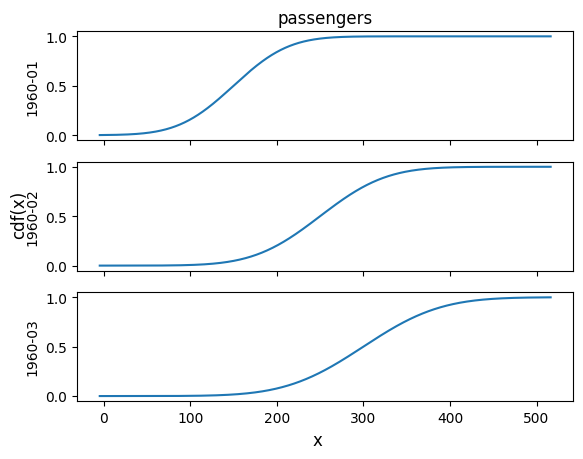

In [29]:
n.plot("cdf")

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'passengers'}, ylabel='1960-01'>,
        <Axes: ylabel='1960-02'>, <Axes: ylabel='1960-03'>], dtype=object))

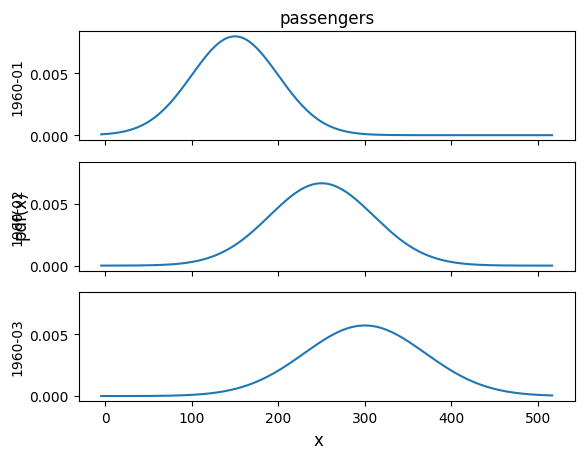

In [30]:
n.plot("pdf")

#### How do the different forecast modes relate to the predictive distribution?

In [31]:
n0.to_df()

,mu,sigma
0,150.0,50.0


`predict_var`: variance of predictive distribution

"single-number metric of uncertainty"

In [32]:
n.var()

,passengers
1960-01,2500
1960-02,3600
1960-03,4900


`predict_quantiles` - same as ppf

In [33]:
n.quantile([0.1, 0.25, 0.5, 0.75, 0.9])

passengers                                           
               0.10        0.25   0.50        0.75        0.90
1960-01   85.922422  116.275512  150.0  183.724488  214.077578
1960-02  173.106906  209.530615  250.0  290.469385  326.893094
1960-03  210.291390  252.785717  300.0  347.214283  389.708610

In [34]:
[n.ppf(0.1), n.ppf(0.5), n.ppf(0.9)]

[         passengers
 1960-01   85.922422
 1960-02  173.106906
 1960-03  210.291390,
          passengers
 1960-01       150.0
 1960-02       250.0
 1960-03       300.0,
          passengers
 1960-01  214.077578
 1960-02  326.893094
 1960-03  389.708610]

`predict_interval`: we pick lower/upper so quantiles are symmetric

e.g., 0.7 coverage -> 0.15 and 0.85 quantiles

**Exercise**: compute symmetric prediction intervals at 0.6 coverage probability,

assuming the above distribution as predictive distribution



for statistics experts, not covered here for sake of simple exposition:

* dependence across time points - by default marginal
* distributions can be non-continuous, mixed, non-parametric

`skpro` supports large number of distributions

* symbolic representation of array distributions
* implementations of base methods (mostly from `scipy`) and advanced methods such as energy/crps

In [35]:
from skpro.registry import all_objects

all_objects("distribution", as_dataframe=True)

,name,object
0,Alpha,<class 'skpro.distributions.alpha.Alpha'>
1,Beta,<class 'skpro.distributions.beta.Beta'>
2,Binomial,<class 'skpro.distributions.binomial.Binomial'>
3,ChiSquared,<class 'skpro.distributions.chi_squared.ChiSqu...
4,Delta,<class 'skpro.distributions.delta.Delta'>
5,Empirical,<class 'skpro.distributions.empirical.Empirical'>
6,Erlang,<class 'skpro.distributions.erlang.Erlang'>
7,Exponential,<class 'skpro.distributions.exponential.Expone...
8,Fisk,<class 'skpro.distributions.fisk.Fisk'>
9,Gamma,<class 'skpro.distributions.gamma.Gamma'>


easy to extend - new distributions can be added via extension templates

#### Formal view of proba predict methods in a single table

$y'$ future data, $y$ past data - considered as random variables

predictions relate to the conditional $X = y' | y$

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[X]$ | `predict` |
| variance forecast | | conditional variance $\mathbb{V}[X]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $Q_{X}(\alpha)$ = the $\alpha$-quantile of $y'\|y$  | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le X \le b) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $X$ | `predict_proba` |

<img src="imgs/distr_overview.png" alt="placeholder" width="100%">

---
### Metrics and diagnostics for probabilistic forecasts


revisiting: types of predictions, types of metrics

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

In [36]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster
from sktime.split import temporal_train_test_split


# step 1: data specification
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=12)

# step 2: specifying forecasting horizon
fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# step 3: specifying the forecasting algorithm
forecaster = ThetaForecaster(sp=12)
# step 4: fitting the forecaster
forecaster.fit(y_train, fh=fh)

ThetaForecaster(sp=12)

In [37]:
# use forecaster above to make probabilistic predictions
y_pred_int = forecaster.predict_interval(coverage=0.95)
y_pred_q = forecaster.predict_quantiles(alpha=[0.05, 0.95])
y_pred_proba = forecaster.predict_proba()

* `y_pred_int` - prediction intervals
* `y_pred_q` - prediction quantiles
* `y_pred_proba` - distribution prediction

how do we know which metrics to pick?

* quantile or interval forecasts -> quantile metrics
* distribution forecasts -> distribution metrics

In [38]:
from skpro.registry import all_objects

# list all proba metrics, with tag for type
all_objects("metric", as_dataframe=True, return_tags="scitype:y_pred")

,name,object,scitype:y_pred
0,AUCalibration,<class 'skpro.metrics._classes.AUCalibration'>,pred_proba
1,CRPS,<class 'skpro.metrics._classes.CRPS'>,pred_proba
2,ConcordanceHarrell,<class 'skpro.metrics.survival._c_harrell.Conc...,pred_proba
3,ConstraintViolation,<class 'skpro.metrics._classes.ConstraintViola...,pred_interval
4,EmpiricalCoverage,<class 'skpro.metrics._classes.EmpiricalCovera...,pred_interval
5,IntervalWidth,<class 'skpro.metrics._classes.IntervalWidth'>,pred_interval
6,LinearizedLogLoss,<class 'skpro.metrics._classes.LinearizedLogLo...,pred_proba
7,LogLoss,<class 'skpro.metrics._classes.LogLoss'>,pred_proba
8,PinballLoss,<class 'skpro.metrics._classes.PinballLoss'>,pred_quantiles
9,SPLL,<class 'skpro.metrics.survival._spll.SPLL'>,pred_proba


In [39]:
# recall: pinball loss for quantile predictions
from skpro.metrics import PinballLoss

pinball_loss = PinballLoss()
pinball_loss(y_test, y_pred_q)

3.492295963333417

recall definition and riddle:

$L_\alpha(y, \widehat{y}) = (y - \hat{y}) \left( \alpha - H(y - \hat{y}) \right)$

where $\alpha\in [0,1]$ is the quantile for which the prediction is made,

and $H$ is the Heaviside function, $H(x) := 0 \text{ if } x < 0,\ 1 \text{ if } x \geq 0$.

**why is this a good metric for quantile forecasts?**

"strict properness"

let $Y$ be random variable. $L$ is proper for $\alpha$-quantiles if

$Q_Y(\alpha) = \displaystyle \argmin_{\widehat{y} \in \mathbb{R}} \mathbb{E} \left[L(Y, \widehat{y})\right]$

in English: the expected loss is minimized by the "ground truth" $\alpha$-quantile of $Y$

(expectation taken over $Y$, i.e., "plausible futures")

**Exercise.** prove that

* the MSE is strictly proper for the mean ("`predict`")
* the MAE is strictly proper for the median ("`predict_quantiles(alpha=0.5)`")

#### metrics for distributional predictions

What is "strictly proper" for `predict_proba`?

Recall, we need to compare distribution with number:

<img src="imgs/proba_losses.png" alt="placeholder" width="100%">

**CRPS = Continuous Ranked Probability Score**

$L(d, y) = \mathbb{E}_{X\sim d}|X-y| - \frac{1}{2}\cdot\mathbb{E}_{X, X'\sim d}|X-X'|$

**first term is "calibration term":** expected MAE, under predictive distribution $d$

"sample one point, average difference to ground truth $y$"

**second term is "sharpness term":** expected absolute variation of the distribution $d$

"sample two points, average absolute difference"

In [40]:
# CRPS = continuous ranked probability score, for distribution predictions
from skpro.metrics import CRPS

crps = CRPS()
crps(y_test, y_pred_proba)

17.54994064789111

theorem: CRPS is strictly proper for the entire distribution!

(any distribution, can be continuous, mixed, discrete such as Poisson)

Exercise: if you replace absolute values with square, it's no longer strictly proper.

#### useful diagnostic plots and metrics

##### interval prediction crossplot and diagnostics

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

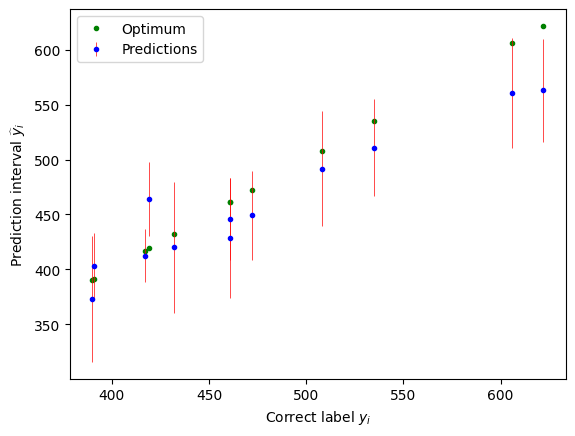

In [41]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_int)

In [42]:
# empirical coverage
# how often is the true value inside the prediction interval (percentage)?
from skpro.metrics import EmpiricalCoverage

empc = EmpiricalCoverage()
empc(y_test, y_pred_int)


0.8333333333333334

In [43]:
# Interval width = (average) width of the prediction interval
from skpro.metrics import IntervalWidth

intv = IntervalWidth()
intv(y_test, y_pred_int)


88.62815603384267

##### predictive quantile calibration plot

In [44]:
y_pred_q_many = forecaster.predict_quantiles(alpha=[x/1000 for x in range(1, 1000)])

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

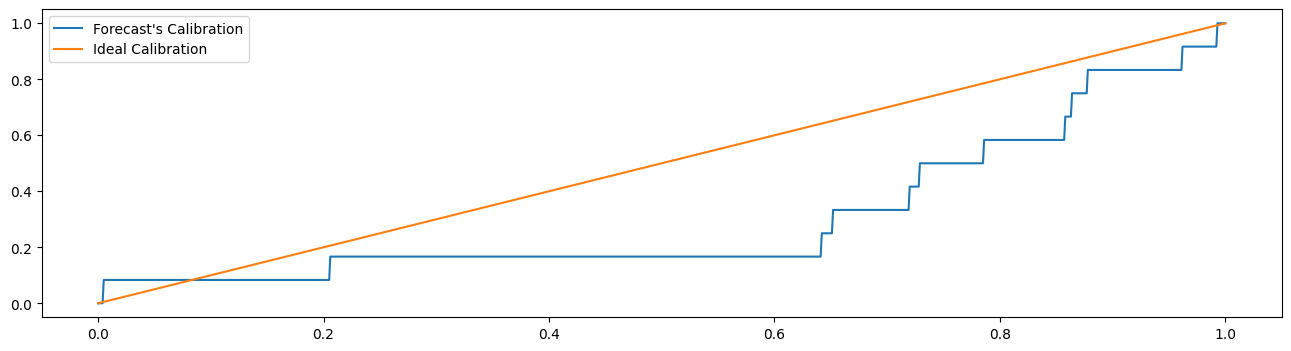

In [45]:
from sktime.utils.plotting import plot_calibration

plot_calibration(y_test, y_pred_q_many)

What does this show?

1. For each ground truth and predictive distribution pair $y_i, d_i$, compute the quantile point of $y_i$ in $d_i$, i.e., $p_i = F_{d_i}(y_i)$
2. order the $p_i$ increasingly, i.e., $p_{(i)}:=$ the $i$-th smallest element of all $p_i$
3. blue curve = plot $p_i$ as a function of $i$; orange curve is $f(x)=x$

For a perfect prediction $d$ of ground truth $y$ (with $y$ considered random), $F_{d}(y)$ is uniformly distributed!

So blue curve should be close to orange curve, for perfect predictions.

"the further away the worse"

In [46]:
# area deviation under the calibration curve:
from skpro.metrics import AUCalibration

aucc = AUCalibration()
aucc(y_test, y_pred_proba)

0.2638888888888889

##### what to pick for probabilistic evaluation?

for interval and quantile predictions:

* `PinballLoss` is the standard choice
* `IntervalWidth` and `EmpiricalCoverage` are informative but should not be used as min/max targets
    * "stupid prediction" has 0 interval width but is compltely off
    * another "stupid prediction" has 100% empirical coverage ... huge intervals
* `PinballLoss` trades off these two so lower = better in the sense of "proper scoring"!

for distributional predictions:

* `CRPS` is the standard choice - "proper scoring rule" and generally applicable
* `LogLoss` can be used but has problems for predictive masses (assumes no discrete part)
* calibration metrics, calibration diagnostics
* survival metrics in time-to-event scenario for censoring (not shown today)

"advanced choices" if weights of under/overestimation etc are known etc

**in forecasting, always combine with proper backtesting regime!**

---
### Tabular probabilistic predictions and reduction

"I want to use `mapie` / `ngboost` / [insert favourite proba reducer here] for forecasting!"

challenge: `mapie` / `ngboost` etc are *tabular* probabilistic regressors, not forecasters

same principle as with reduction for point forecasts can be applied! Recall:

![](./imgs/forecasting-to-regression-reduction.png)

`skpro` is a package with unified interface for:

* probability distribution objects (see above)
* tabular probabilistic regressors
* tabular time-to-event predictors

In [47]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.regression.bootstrap import BootstrapRegressor
from sklearn.linear_model import LinearRegression

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# step 2: specifying the regressor
# example - bootstrap regressor applied to linear regression
reg_tabular = LinearRegression()
boot_reg = BootstrapRegressor(reg_tabular)

# step 3: fitting the model to training data
boot_reg.fit(X_train, y_train)

# step 4: predicting labels on new data
y_pred_proba = boot_reg.predict_proba(X_test)
y_pred_int = boot_reg.predict_interval(X_test)

(<Figure size 640x480 with 5 Axes>,
 array([<Axes: title={'center': 'target'}, ylabel='302'>,
        <Axes: ylabel='181'>, <Axes: ylabel='150'>, <Axes: ylabel='202'>,
        <Axes: ylabel='228'>], dtype=object))

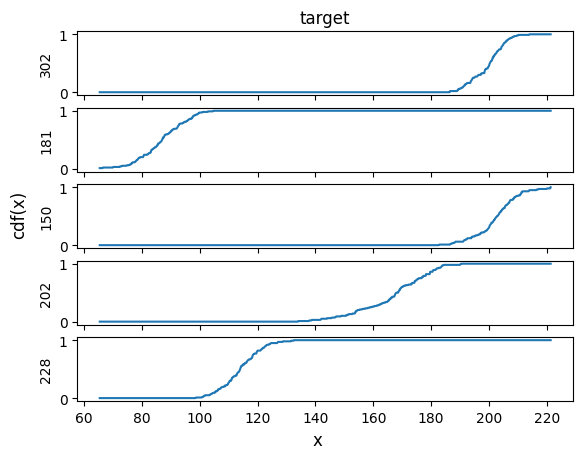

In [48]:
y_pred_proba.head().plot()

In [49]:
# compare lower_upper 90% interval with cdf plot
y_pred_int.head()

target            
            0.9            
          lower       upper
302  189.212116  207.908107
181   72.894995   99.371459
150  188.100199  213.963207
202  141.930582  183.424030
228  101.902002  124.450872

`skpro` can be used on its own if your problem is non temporally ordered!

`skpro` regressors can be used inside (many of the) `sktime` reducers:

In [50]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.compose._reduce import DirectTabularRegressionForecaster
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)

# Create a forecaster from the tabular regressor by wrapping it in `make_reduction`
forecaster = DirectTabularRegressionForecaster(boot_reg, window_length=16)

# fit the forecaster
forecaster.fit(y=y_train, fh=fh)

# make proba prediction
y_pred_int = forecaster.predict_interval()

In [51]:
y_pred_int

Number of shampoo sales            
                            0.9            
                          lower       upper
Period                                     
1993-07              209.861907  264.325178
1993-08              226.000000  295.857447
1993-09              260.095834  298.507458
1993-10              289.900000  366.562573
1993-11              276.347039  375.248330
1993-12              264.500000  379.287016
1994-01              264.500000  341.333532
1994-02              339.700000  394.644309
1994-03               99.600000  404.958746
1994-04              248.964706  439.813061
1994-05              361.467828  425.174701
1994-06              401.300000  438.286196

to build pipelines flexibly, use `YfromX` with `Lag`

Example: building a feature extraction pipeline with 1 lag and fourier features

In [52]:
from sktime.datasets import load_longley
from sktime.forecasting.compose import YfromX
from sktime.transformations.compose import YtoX
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.lag import Lag

# multivariate data with exogenous variables
y, X = load_longley()
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)


# forecaster that predicts y from exogenous X
f = YfromX(boot_reg)

# we add a lag of 1 to exogeneous X
lagged_y_trafo = YtoX() * Lag(1, index_out="original") * Imputer()
# we need to specify index_out="original" as otherwise ARIMA gets 1 and 2 ahead
# we need to add imputer, or the lagged y will have missing values in the first row

# fourier features
fourier_features = FourierFeatures(sp_list=[24, 24 * 7], fourier_terms_list=[10, 5])

# forecaster that uses fourier features and lagged y
forecaster = (lagged_y_trafo + fourier_features)**f 

forecaster.fit(y_train, X=X_train, fh=[1])  # try to forecast next year

y_pred = forecaster.predict(X=X_test)  # dummy X to predict next year
y_pred_proba = forecaster.predict_proba(X=X_test)  # dummy X to predict next year

In [53]:
y_pred_proba.quantile([0.1, 0.5, 0.9])

TOTEMP                           
                0.1           0.5          0.9
Period                                        
1959    65231.00625  66035.322372  66967.86352

#### Time-to-event modeling

time-to-event = waiting time = failure time = survival time etc

* medical, e.g., survival after cancer therapy
* manufacturing, e.g., time until equipment failure
* retail, e.g., time until customer churn (or, does not churn)
* logistics, e.g., time until request arrival


Tabular case: samples with

* a feature vector, row of a data frame
* a label, either:
    * exact time of occurrence, or
    * a statement "time was t or later" (has not happened yet) = "censoring"

In [54]:
# simulated toy dataset, lung cancer survival times
import numpy as np

# demographics - age and smoker yes/no
age = np.random.uniform(low=20, high=100, size=50)
smoker = np.random.binomial(1, 0.3, size=50)

# actual survival time
scale = 200 / (0.5 * age + 30 * smoker)
survival = scale * np.random.weibull(1, size=50)

# patients are observed only for 5 years
# if they surviva 5 years, we know they survived 5 years, but not exact time of death
censored = survival > 5
observation = np.minimum(survival, 5)

`skpro` represents this information in an `sklearn`-like interface:

In [55]:
import pandas as pd

# features
X = pd.DataFrame({"age": age, "smoker": smoker})

# time of survival or censoring
y = pd.DataFrame({"time": observation})

# indicator whether event was observed or censored
# censored = 1 = True, observed = 0 = False
# variable names should be the same as for y
C = pd.DataFrame({"time": censored})

In [56]:
X.head()

,age,smoker
0,68.699748,0
1,70.700020,1
2,50.512551,0
3,27.986919,1
4,89.037459,0


In [57]:
y.head()

,time
0,2.008653
1,0.058306
2,2.909133
3,5.000000
4,1.518111


In [58]:
C.head()

,time
0,False
1,False
2,False
3,True
4,False


In [59]:
from sklearn.model_selection import train_test_split

from skpro.survival.coxph import CoxPH

# step 1: data specification
# X, y, C, as above
X_train, X_new, y_train, _, C_train, _ = train_test_split(X, y, C)

# step 2: specifying the regressor
# example - Cox proportional hazards model from statsmodels
surv_model_cox = CoxPH()

# step 3: fitting the model to training data
surv_model_cox.fit(X_train, y_train, C_train)

# step 4: predicting labels on new data

# full distribution prediction
y_pred_proba_cox = surv_model_cox.predict_proba(X_new)

In [60]:
# mean predicted survival time
y_pred_proba_cox.mean().head()

,time
4,2.880712
32,3.027246
19,2.955655
48,3.632691
10,3.666316


(<Figure size 640x480 with 5 Axes>,
 array([<Axes: title={'center': 'time'}, ylabel='4'>, <Axes: ylabel='32'>,
        <Axes: ylabel='19'>, <Axes: ylabel='48'>, <Axes: ylabel='10'>],
       dtype=object))

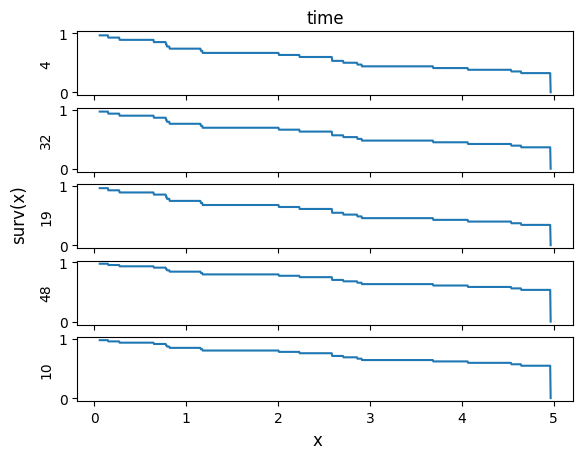

In [61]:
# plot of survival functions
y_pred_proba_cox.iloc[range(5)].plot("surv")

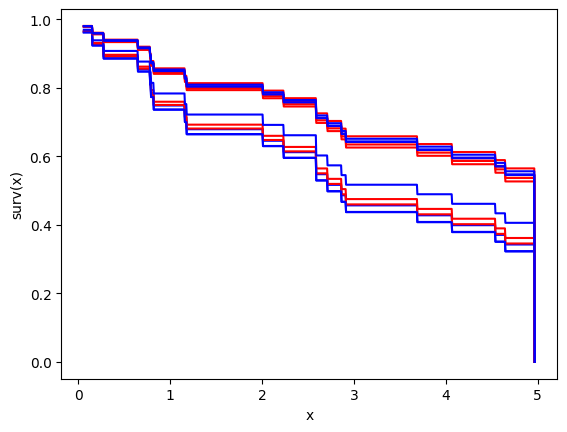

In [62]:
# plotting survival functions in one figure, smokers in red
from matplotlib.pyplot import subplots

_, ax = subplots()

for i in range(len(y_pred_proba_cox)):
    ax = y_pred_proba_cox.iat[i, 0].plot("surv", ax=ax, color=["b", "r"][smoker[i]])

same example with parametric Weibull distribution:

In [63]:
from sklearn.model_selection import train_test_split

from skpro.survival.aft import AFTWeibull

# step 1: data specification
# X, y, C, as above
X_train, X_new, y_train, _, C_train, _ = train_test_split(X, y, C)

# step 2: specifying the regressor
# example - Cox proportional hazards model from statsmodels
surv_model_aft = AFTWeibull()

# step 3: fitting the model to training data
surv_model_aft.fit(X_train, y_train, C_train)

# step 4: predicting labels on new data

# full distribution prediction
y_pred_proba_aft = surv_model_aft.predict_proba(X_new)

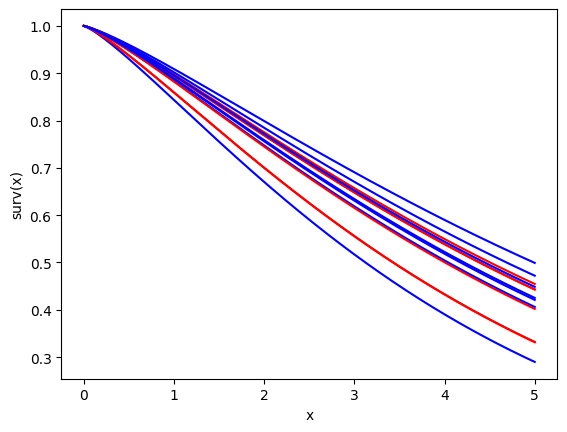

In [64]:
# plotting survival functions in one figure, smokers in red
from matplotlib.pyplot import subplots

_, ax = subplots()

for i in range(len(y_pred_proba_cox)):
    ax = y_pred_proba_aft.iat[i, 0].plot(
        "surv", ax=ax, color=["b", "r"][smoker[i]], x_bounds=[0, 5]
    )

finding genuine survival models in `skpro`:

In [65]:
from skpro.registry import all_objects

# time-to-event predictors have "regressor_proba" type, i.e., probabilistic regressors
# the tag "capability:survival" = True indicates models that make use of C
all_objects(
    "regressor_proba", as_dataframe=True, filter_tags={"capability:survival": True}
).head()

,name,object
0,AFTFisk,<class 'skpro.survival.aft._aft_lifelines_fisk...
1,AFTLogNormal,<class 'skpro.survival.aft._aft_lifelines_logn...
2,AFTWeibull,<class 'skpro.survival.aft._aft_lifelines_weib...
3,AalenAdditive,<class 'skpro.survival.additive._aalen_lifelin...
4,ConditionUncensored,<class 'skpro.survival.compose._reduce_cond_un...


use survival models in `sktime` reductions if:

* observations are "waiting time to next event"
* predicting waiting time given temporal history

---

### Reduction revisited

There are five types of relevant reductions here!

1. probabilistic mode is added to sklearn regressor

    * = reduction from proba tabular reg to non-proba tabular reg ("sklearn reg")
    * examples: `mapie`, `ngboost`, `cyclic-boosting`, EnbPI, jackknife-plus-after-bootstrap
    * `skpro` provides these in unified interface - `MapieRegressor`, `CyclicBoosting`, `EnbPIRegressor`, etc
    * most of the above use variants of *non-temporal* bootstrap

2. probabilistic forecaster is constructed with a probabilistic sklearn regressor

    * = reduction from proba forecast ot proba tabular reg
    * first construct an `skpro` regressor
    * then pass it to the `sktime` reducer, e.g., `DirectReductionForecaster`

3. probabilistic mode is added to sktime forecaster

    * = reduction from proba forecast to non-proba forecast
    * examples: `SquaringResiduals`, `ConformalIntervals`, `EnbPIForecaster`

4. non-proba forecaster is constructed with sklearn regressor

    * = reduction from proba forecast to non-proba forecast
    * seen in lectures 1 and 2 - e.g., direct, recursive, dirrec, YfromX reductions

5. proba forecaster directly constructed from non-proba sklearn regressor

    * = reduction from proba forecast to non-proba tabular
    * can be achieved by 2 + 1, or by 3 + 4
    * rarer: genuine methods of this type, e.g., some "native" EnbPI/conformal for TS

![](./imgs/proba_reductions.png)

---

## Summary & retrospective 

### what to use now? We have seen (in rough order of complexity)

* genuine proba forecasters, e.g., `ARIMA` from `statsmodels`
* forecasting proba adders such as `ConformalIntervals`, `EnbPIForecaster` applied to non-proba forecasters
* temporal bootstraps (`tsbootstrap`) plus bootstrap interval adder `BaggingForecaster`, applied to non-proba fcst
* reduction of proba forecasting to proba regression
    * proba regression can be further reduced to non-proba regression with tabular proba adders

What is best?

* no universally best method, no larger-scale benchmark -> interesting research question!
* start simple, complex models need to "earn" their place
* use uncontaminated evaluation workflow (`evaluate`)!
* more well-understood or widely used choices in tabular regression
    * M4 proba winners made heavy use of reduction (tabular, global pooling) - easy to access

Important: all typically need deseasonalize, detrend, stationarize before applying proba estimators

* vanilla models typically assume some type of stationarity, no periodicity
* proba adders typically assume this too
* temporal bootstraps typically assume this
* reduction to tabular also assumes this implicitly through iid assumption of tabular regressors

Important: in practice, feature extraction can make substantial difference!

* not systematically presented today - see feature extraction, pipelines tutorial!
* integration with rich feature extraction tools via `sktime`

---
## Easy to extend!

For 3rd party code base, your own package (listing at `sktime`), or in `sktime`

All objects above are first class citizens with their own extension templates!

* probability distributions
* probabilistic metrics
* tabular probabilistic regressors
* probabilistic forecasters, of course

["implementing estimator" developer guide](https://www.sktime.net/en/stable/developer_guide/add_estimators.html)

use extension template from `sktime` or `skpro`, folder `extension_templates`

---
## Under development - join to contribute!

* uniformization/refactor `sktime` / `skpro`
* simulation interface for temporally dependent forecasts
* distribution forecast related meta-algorithms such as calibration, pipeline elements
* hierarchical reconcilers for probabilistic forecasters
* Bayesian probabilistic interfaces, `pymc` based models

Wishlists and user feedback appreciated!

[skpro issue tracker](https://github.com/sktime/skpro/issues)

[sktime issue tracker](https://github.com/sktime/sktime/issues)

[community discord](https://discord.com/invite/54ACzaFsn7)

---

### Credits

notebook creation: fkiraly